<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Projects/blob/main/Beginner/PyTorch-FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 37.4 MB/s eta 0:00:00


In [2]:
!pip install torchviz

In [3]:
# Import Libraries
import torch
from torch import nn
import torchvision
import torchmetrics as tm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchviz import make_dot

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
# Download FashionMNIST Dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

print("Total Classes: ", len(train_dataset.classes))

test_dataset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

# Load Data
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size = 64, shuffle = False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.14MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 59.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.0MB/s]


Total Classes:  10


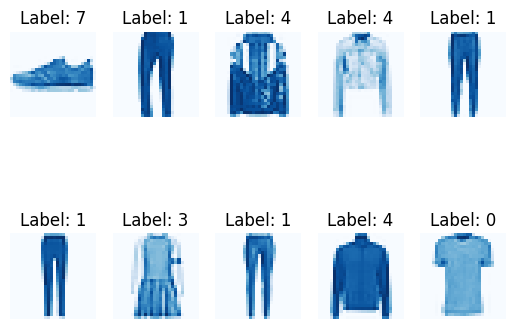

In [6]:
# Display Training Images
data_iter = iter(train_dl)
imgs, lbls = next(data_iter)

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(imgs[i].squeeze(), cmap = "Blues")
  plt.title(f'Label: {lbls[i].item()}')
  plt.axis('off')
plt.show()

In [7]:
# Define Convolutional Neural Network
class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    self.c1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.mp1 = nn.MaxPool2d(kernel_size=2)

    self.c2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.mp2 = nn.MaxPool2d(kernel_size = 2)

    self.drop = nn.Dropout(0.3)
    self.flat = nn.Flatten()
    self.cls = nn.Linear(64*7*7, num_classes)

  def forward(self, x):
    x = self.c1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.mp1(x)

    x = self.c2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.mp2(x)

    x = self.drop(x)
    x = self.flat(x)
    x = self.cls(x)

    return x

In [8]:
# Set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Initialize Model
cnn = CNN(num_classes=10).to(device)

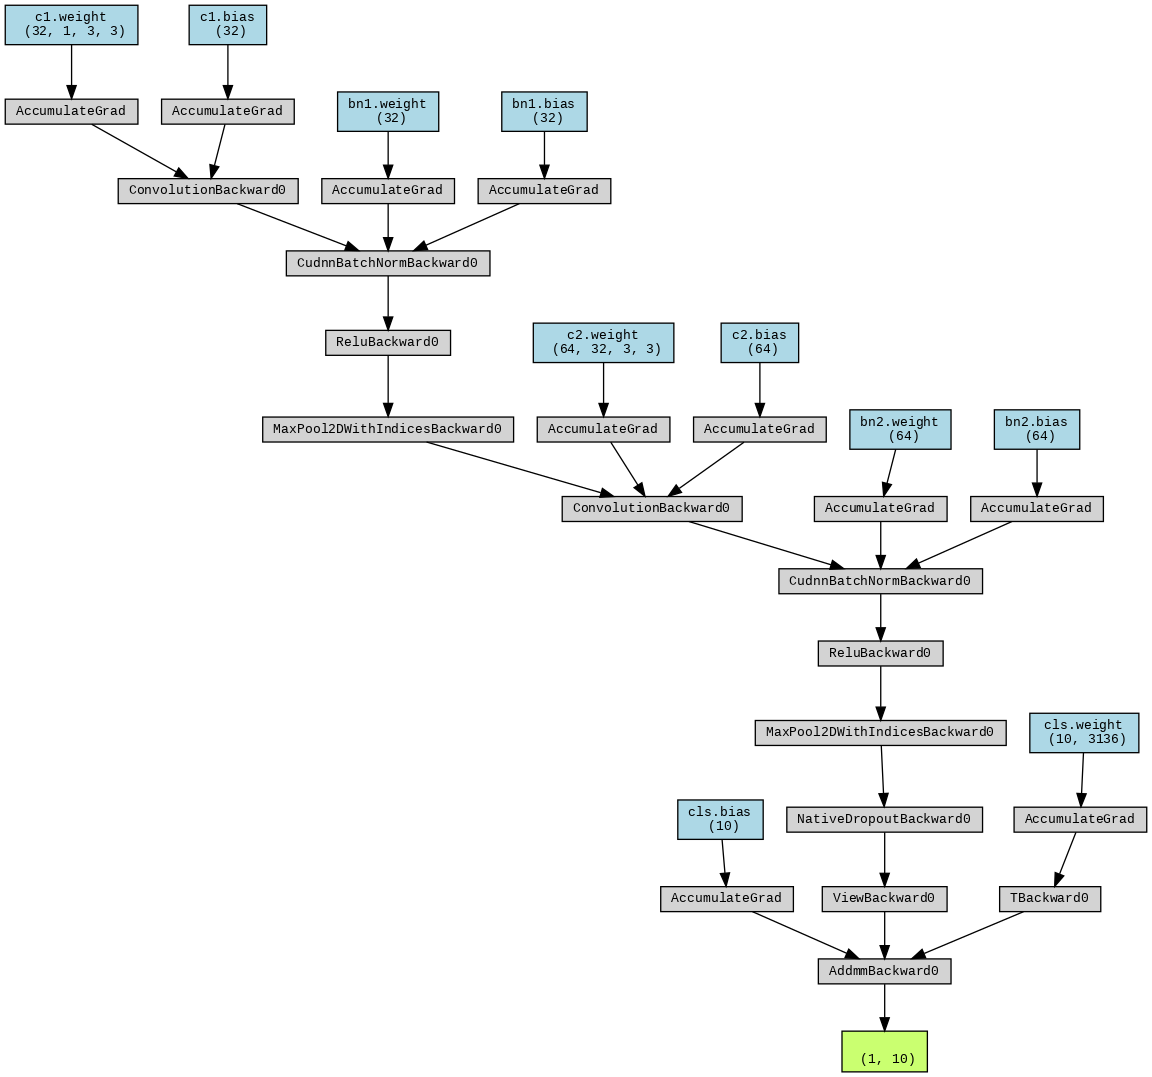

In [10]:
# Generate Dummy Input To Visualze The Graph
dummy_input = torch.randn(1, 1, 28, 28).to(device)
output_graph = cnn(dummy_input)

# Visualize The Commputational Graph
dot = make_dot(
    output_graph,
    params= dict(list(cnn.named_parameters()))
)

dot.render("cnn_model_graph", format = "png", cleanup = True)

# Display The Visualization
Image(filename = "cnn_model_graph.png")

In [11]:
# Define Loss Function and Optimizer
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)

# Define Learning Rate Scheduler
step_size = 5 # Change LR After Every 5 Epochs
gamma = 0.5 # Reduce LR By 50% After Every Step
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)

In [12]:
# Training Loop
train_loss = []
val_loss = []
lr_history = []
epochs = 25

for epoch in range(epochs):
  cnn.train()
  epoch_loss = 0.0

  for images, labels in train_dl:
    images, labels = images.to(device), labels.to(device)
    # print(labels.shape, labels[:5])
    optimizer.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(cnn.parameters(), max_norm=5.0) # Limits Gradient Norm To Avoid Explosion
    # print(cnn.cls.weight.grad.abs().mean().item())
    optimizer.step()
    epoch_loss += loss.item()

  epoch_loss = epoch_loss / len(train_dl)
  train_loss.append(epoch_loss)

  # Validation Loop
  cnn.eval()
  running_val_loss = 0.0

  with torch.no_grad():
    for images, labels in test_dl:
      images, labels = images.to(device), labels.to(device)
      outputs = cnn(images)
      loss = criterion(outputs, labels)
      running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(test_dl)
    val_loss.append(avg_val_loss)

  current_lr = optimizer.param_groups[0]['lr']

  print(f'Epoch [{epoch+1}/{epochs}], Current LR: {current_lr}, Training Loss: {epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  # Step The LR Scheduler
  scheduler.step()

Epoch [1/25], Current LR: 0.001, Training Loss: 0.4221, Validation Loss: 0.3055
Epoch [2/25], Current LR: 0.001, Training Loss: 0.2883, Validation Loss: 0.2766
Epoch [3/25], Current LR: 0.001, Training Loss: 0.2590, Validation Loss: 0.2780
Epoch [4/25], Current LR: 0.001, Training Loss: 0.2359, Validation Loss: 0.2490
Epoch [5/25], Current LR: 0.001, Training Loss: 0.2209, Validation Loss: 0.2385
Epoch [6/25], Current LR: 0.0005, Training Loss: 0.1936, Validation Loss: 0.2262
Epoch [7/25], Current LR: 0.0005, Training Loss: 0.1830, Validation Loss: 0.2235
Epoch [8/25], Current LR: 0.0005, Training Loss: 0.1756, Validation Loss: 0.2227
Epoch [9/25], Current LR: 0.0005, Training Loss: 0.1706, Validation Loss: 0.2251
Epoch [10/25], Current LR: 0.0005, Training Loss: 0.1645, Validation Loss: 0.2198
Epoch [11/25], Current LR: 0.00025, Training Loss: 0.1489, Validation Loss: 0.2212
Epoch [12/25], Current LR: 0.00025, Training Loss: 0.1475, Validation Loss: 0.2162
Epoch [13/25], Current LR: 0

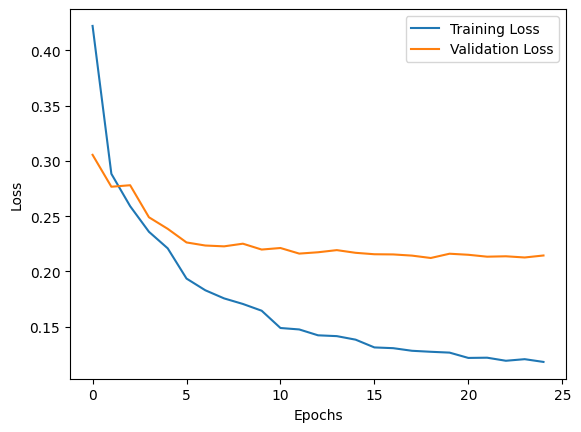

In [13]:
# Plot Learning Curves
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

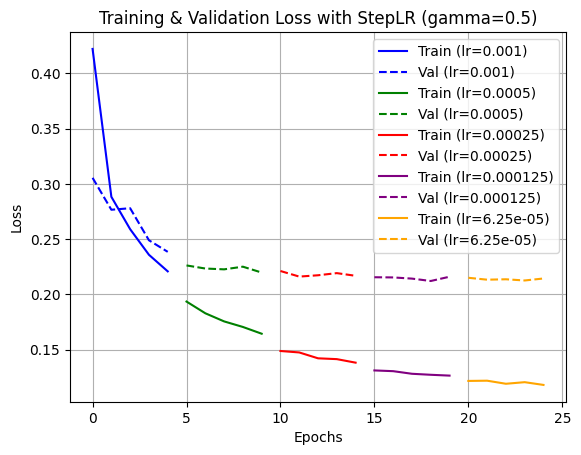

In [14]:
# Color-code The Learning Curves

lr_schedule = [
    (0.001, 5),
    (0.0005, 5),
    (0.00025, 5),
    (0.000125, 5),
    (0.0000625, 5)
]

colors = ['blue', 'green', 'red', 'purple', 'orange']

epoch_start = 0
for (lr, num_epochs), color in zip(lr_schedule, colors):
    epoch_end = epoch_start + num_epochs

    plt.plot(
        range(epoch_start, epoch_end),
        train_loss[epoch_start:epoch_end],
        color=color,
        label=f'Train (lr={lr})'
    )

    plt.plot(
        range(epoch_start, epoch_end),
        val_loss[epoch_start:epoch_end],
        color=color,
        linestyle='--',
        label=f'Val (lr={lr})'
    )

    epoch_start = epoch_end

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss with StepLR (gamma=0.5)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Define Evaluation Metrics
accuracy = tm.Accuracy(
    task = "multiclass",
    num_classes = 10,
    average = "macro"
).to(device)

precision = tm.Precision(
    task = "multiclass",
    num_classes = 10,
    average = "macro"
).to(device)

recall = tm.Recall(
    task = "multiclass",
    num_classes = 10,
    average = "macro"
).to(device)

In [16]:
# Initialize Confusion Matrix
confusion_matrix = tm.ConfusionMatrix(
    task = "Multiclass",
    num_classes = 10
).to(device)

In [17]:
# Evaluate Model On Test Set
cnn.eval()

with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    output = cnn(images)
    predictions = torch.argmax(output, dim=1)

    accuracy(predictions, labels)
    precision(predictions, labels)
    recall(predictions, labels)

    confusion_matrix(predictions, labels)

accuracy_score = accuracy.compute()
precision_score = precision.compute()
recall_score = recall.compute()

print(f'Accuracy: {accuracy_score:.4f}')
print(f'Precision: {precision_score:.4f}')
print(f'Recall: {recall_score:.4f}')

Accuracy: 0.9279
Precision: 0.9276
Recall: 0.9279


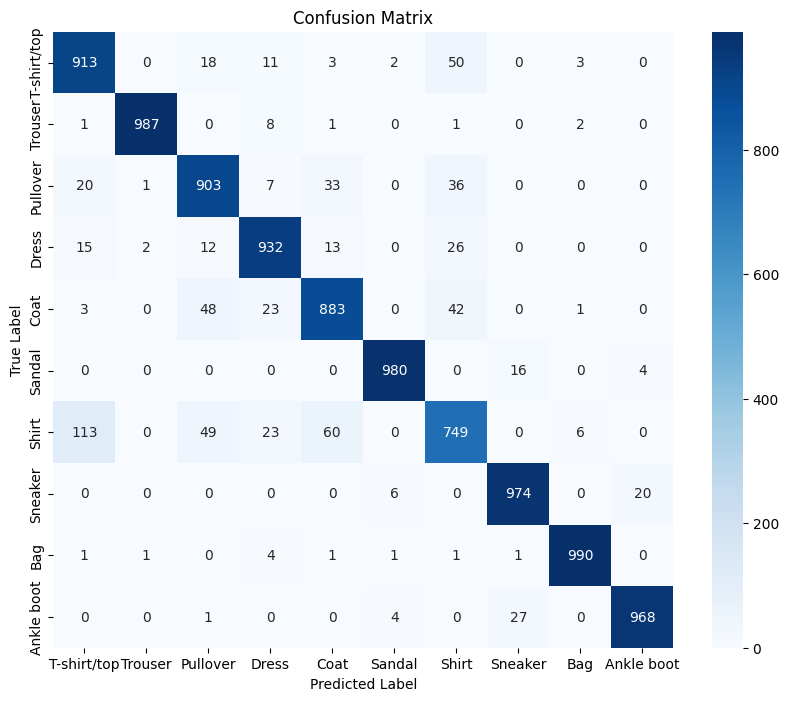

In [18]:
# Compute & Plot Confusion Matrix
cm = confusion_matrix.compute().cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Model Interprebility

In [21]:
# Saliency Map
def saliency_map(model, dataloader, device):
    # Set the model to evaluation mode
    model.eval()

    # Get one FashionMNIST sample
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    image = images[0]               # Shape: [Channel, Width, Height]
    label = labels[0]

    # Add batch dimension
    image = image.unsqueeze(0)      # Shape: [Batch, Channel, Width, Height]

    # Enable gradient tracking on the input
    image.requires_grad_(True)

    # Forward pass through the model
    output = model(image)           # Shape: [1, 10]

    # Choose the class to explain
    predicted_class = torch.argmax(output, dim=1).item()
    target_score = output[0, predicted_class]

    model.zero_grad()
    if image.grad is not None:
        image.grad.zero_()

    # Backpropagation
    target_score.backward()

    # Extract Saliency Map
    saliency = image.grad.detach()  # Shape: [Batch, Channel, Width, Height]
    saliency = saliency.squeeze()   # Shape: [Width, Height]
    saliency = saliency.abs()

    # Normalize Salienct Map
    saliency -= saliency.min()
    saliency /= saliency.max() + 1e-8

    # Prepare original image for plotting
    original_image = image.detach().squeeze().cpu()

    saliency = saliency.cpu()

    # Plot results
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"Original Image (Label: {label.item()})")
    plt.imshow(original_image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Saliency Map (Class: {predicted_class})")
    plt.imshow(saliency, cmap="hot")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

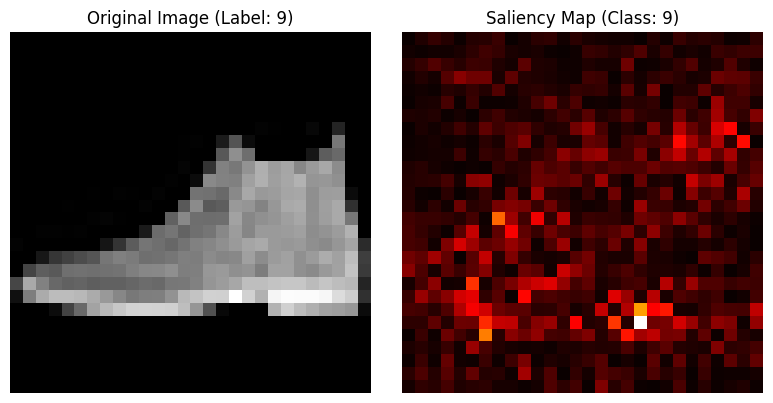

In [22]:
saliency_map(cnn, test_dl, device)